# Benchmarking lung integration

In [1]:
import numpy as np
from anndata import AnnData
import scanpy as sc

from scib_metrics.benchmark import Benchmarker

In [2]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata)


/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preproces

In [5]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

Below we sort the anndata so batches are contiguous. This is necessary to run scanorama.

In [6]:
adata = adata[adata.obs.batch.sort_values().index].copy()

In [7]:
%%capture
import scanpy.external as sce
sce.pp.scanorama_integrate(adata, "batch", adjusted_basis="Scanorama")

In [29]:
import pyliger
bdata = adata.copy()
bdata.X = bdata.layers["counts"]
bdata = bdata[:, bdata.var.highly_variable].copy()
# List of adata per batch
batch_cats = bdata.obs.batch.cat.categories
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    ad.uns['var_gene_idx'] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k = 20)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(bdata.obs.batch.cat.categories):
    adata[adata.obs.batch == b].obsm["LIGER"] = liger_data.adata_list[i].obsm["H_norm"]

/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
 20%|██        | 6/30 [00:23<01:34,  3.93s/it]

In [8]:
from harmony import harmonize
Z = harmonize(adata.obsm["X_pca"], adata.obs, batch_key = "batch")
adata.obsm["Harmony"] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


In [9]:
%%capture
import scvi
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=246` reached.


In [10]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "Harmony", "scVI"],
    pre_integrated_embedding_obsm_key="X_pca",
    n_jobs=6,
)
bm.benchmark()


Embeddings: 100%|██████████| 3/3 [01:12<00:00, 24.09s/it]


In [11]:
bm.get_results()

,Isolated labels,Silhouette label,cLISI,Silhouette batch,PCR comparison,iLISI,KBET,Batch correction score,Bio conservation score,Total score
Embedding,,,,,,,,,,
Unintegrated,0.0,1.0,1.0,0.66785,0.0,0.0,0.0,0.166962,0.666667,0.466785
Harmony,0.10306,0.0,0.0,1.0,0.697435,1.0,1.0,0.924359,0.034353,0.390356
scVI,1.0,0.509267,0.27949,0.0,1.0,0.806014,0.462357,0.567093,0.596252,0.584589
Metric Type,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


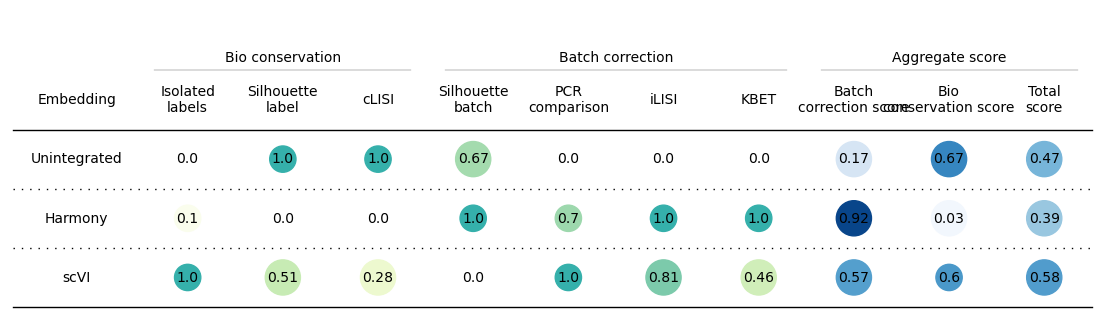

In [12]:
bm.plot_results_table()

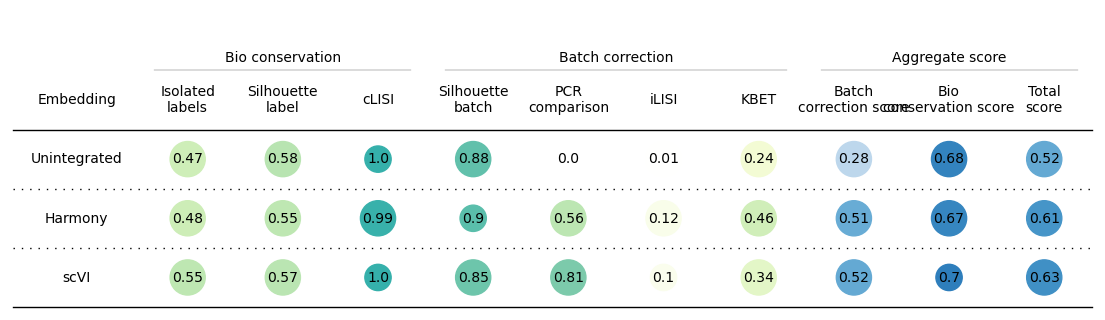

In [13]:
bm.plot_results_table(min_max_scale=False)